**Data Enigeering**

# [Repositorio](https://github.com/soyHenry/PI_ML_OPS/tree/PT?tab=readme-ov-file)

# [ Link de entrega](https://docs.google.com/forms/d/e/1FAIpQLSenq20TbWCWsjScnyuawT4BMhXrvUEokGaqWx05GdppuzrLkA/viewform)


# **NOTA IMPORTANTE**

durante este Jupyter Notebook se verá repetidamente la utilización del comando

```
del (variable o librería)
```
Este comando es utilizado para liberar memoria, ya que la limitación de memoria al momento de realizar este proyecto es de 12.7 GB, los cuales rápidamente se ven sobrepasados si no se realiza esta limpieza, por lo mismo algunas decisiones tomadas durante este proyecto consideran la limitación de memoria, las cuales serán claramente señaladas.



# **Definición de autoguardado, montaje de Google Drive y navegación a carpeta correspondiente.**

Se puede omitir este paso si se trabaja en local

In [1]:
%autosave 60
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/PI01_Misael_Garcia_Torres

Autosaving every 60 seconds
Mounted at /content/drive
/content/drive/MyDrive/Github/PI01_Misael_Garcia_Torres


# **Preparación y carga de datos**

## **Importación de librerías y descarga de recursos necesarios para el proyecto:**


*   `zipfile` para desempaquetar archivos .zip.
*   `gzip` para procesar archivos .gz.
*   `json` para procesar archivos .json.
*   `pandas` para realisar análisis de datos.
*   `numpy` para realisar cálculos matemáticos y estadísticos.
*   `matplotlib` para realisar gráficos de los datos.
*   `ast` para evaluar expresiones literales.
*   `nltk`, `SentimentIntensityAnalyser` y descarga del `vader_lexicon` para realizar análisis de sentimientos.
*   `WordCloud` para realizar nubes de palabras.
*   `Counter` para realizar conteo de palabras.
*   `cosine_similarity` para realizar la matriz de similitud del coseconteo de palabras.
*   `seaborn` para realisar un heatmap.

In [2]:
import zipfile, gzip, json, ast, nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## **Extracción de ficheros del archivo PI MLOps - STEAM.zip.**

In [3]:
zipfile.ZipFile('PI MLOps - STEAM.zip', 'r').extractall()
del zipfile

## **Definición de funciones extraer_json y extraer_ast, funciones para la extracción de datos de los archivos .gz:**

*   `extraer_json()` hace uso de la función `json.loads()` para hacer la carga de datos al DataFrame.
*   `extraer_ast()` hace uso de la función `ast_literal_eval()` para hacer la carga de datos al DataFrame.




In [4]:
def extraer_json(ruta):
    with gzip.open(ruta, 'rb') as archivo:
        datos = [json.loads(fila) for fila in archivo]
    return pd.DataFrame(datos)

def extraer_ast(ruta):
    with gzip.open(ruta, 'rb') as archivo:
        datos = [ast.literal_eval(fila.decode('utf-8')) for fila in archivo]
    return pd.DataFrame(datos)

## **Importación de datos a sus respectivos DataFrames.**

In [5]:
df_juegos = extraer_json('PI MLOps - STEAM/steam_games.json.gz')
df_reviews = extraer_ast('PI MLOps - STEAM/user_reviews.json.gz')
df_items = extraer_ast('PI MLOps - STEAM/users_items.json.gz')
del extraer_json; del extraer_ast; del gzip; del json

# **EDA y ETL**

## **Limpieza de DataFrames.**

*   Registros totalmente vacíos.
*   Registros duplicados.

In [6]:
df_juegos.dropna(how="all", inplace=True)
df_reviews.dropna(how="all", inplace=True)
df_items.dropna(how="all", inplace=True)
df_juegos.drop_duplicates(subset=['title'], inplace=True)
df_reviews.drop_duplicates(subset=['user_id'], inplace=True)
df_items.drop_duplicates(subset=['user_id'], inplace=True)

## **Modificaciones aplicadas para manejo de errores:**

*   Reemplazo de datos faltantes y erroneos en `df_juegos.publisher` por valor nulo ("none").
*   Reemplazo de datos faltantes en `df_juegos.genres` por valor nulo ("[ ]").
*   Reemplazo de datos faltantes en `df_juegos.app_name` por valor correspondiente en `df_juegos.title` y viceversa.
*   Eliminación de columna `df_juegos.title`.
*   Reemplazo de datos faltantes en `df_juegos.url` por valor nulo ("").
*   Corrección de datos incorrectos en `df_juegos.release_date` al formato (año-mes-día).
*   Reemplazo de Datos faltantes e inválidos en `df_juegos.release_date` por la fecha "2222-02-22".
*   Reemplazo de datos faltantes en `df_juegos.tags` por valor nulo ("[ ]").
*   Reemplazo de datos faltantes en `df_juegos.reviews_url` por el enlace a la página oficial de Steam ("https://store.steampowered.com").
*   Reemplazo de datos faltantes en `df_juegos.specs` por valor nulo ("[ ]").
*   Reemplazo de datos faltantes en `df_juegos.price` por "-1", mientras que "Free", "Free to play" y variaciones se identificaron con "0".
*   Reemplazo de datos faltantes en `df_juegos.developer` por un valor nulo ("[ ]").
*   Eliminción de registro si `df_juegos.app_name` y `df_juegos.title` no presentan datos.
*   Conversión de los datos en `df_juegos.id` a valores numéricos
*   Corrección de datos faltantes en `df_juegos.id`, creando nuevas "id" continuando la numeración máxima del registro.
*   cambio de nombre de columna de `df_juegos.id` de "id" a "item_id"
*   Unión y ordenamiento (alfabético) de `df_juegos.tags` y `df_juegos.genres`, se mantendrá sólo `df_juegos.tags`
*   Ordenamiento de `df_juegos.specs` por orden alfabético
<br><br>
*   Desempaquetado de datos de `df_reviews.reviews`, creando las columnas `df_reviews.funny`, `df_reviews.posted`, `df_reviews.last_edited`, `df_reviews.item_id`, `df_reviews.helpful`, `df_reviews.recommend` y `df_reviews.review`, además, se elimina la columna original `df_reviews.reviews`.
*   Reemplazo de datos de `df_reviews.funny` por sólo valores numéricos.
*   Reemplazo de valores vacío en `df_reviews.last_edited` por "not edited".
<br><br>
*   Desempaquetado de datos de `df_items.items`, creando las columnas `df_items.item_id`, `df_items.item_name`, `df_items.playtime_forever` y `df_items.playtime_2weeks`, además, se elimina la columna original `df_items.items`.

In [7]:
# Manejo de datos faltantes
df_juegos['publisher'].fillna('(none)', inplace=True)
df_juegos['publisher'].replace('-', '(none)', inplace=True)
df_juegos['publisher'].replace('---', '(none)', inplace=True)
df_juegos['genres'].fillna('[]', inplace=True)
df_juegos['app_name'].fillna(df_juegos['title'], inplace=True)
df_juegos['title'].fillna(df_juegos['app_name'], inplace=True)
df_juegos['url'].fillna('', inplace=True)
df_juegos['release_date'].fillna('2222-02-22', inplace=True)
df_juegos['tags'].fillna('', inplace=True)
df_juegos['reviews_url'].fillna('https://store.steampowered.com', inplace=True)
df_juegos['specs'].fillna('[]', inplace=True)
df_juegos['price'].fillna(-1, inplace=True)
df_juegos['price'].replace({'Free': 0, 'Free To Play': -0, 'Free Demo': 0, 'Free HITMAN™ Holiday Pack': 0, 'Free Mod': 0, 'Free Movie': 0, 'Free to Play': 0, 'Free to Try': 0, 'Free to Use': 0, 'Install Now': 0, 'Install Theme': 0, 'Play Now': -2, 'Play WARMACHINE: Tactics Demo': 0, 'Play for Free!': 0, 'Play the Demo': 0, 'Starting at $449.00': -2, 'Starting at $499.00': -2, 'Third-party': -2}, inplace=True)
df_juegos['developer'].fillna('[]', inplace=True)

# Eliminación de registro en ausencia de app_name y title
df_juegos.dropna(subset=['app_name', 'title'], how='all', inplace=True)

# conversión de "id" a valores numéricos
df_juegos['id'] = pd.to_numeric(df_juegos['id'], errors='coerce')

# Generación de nuevos "id"
id_maxima = df_juegos['id'].max()
sin_id = df_juegos[df_juegos['id'].isna()]
nuevas_id = range(int(id_maxima) + 1, int(id_maxima) + 1 + len(sin_id))
df_juegos.loc[df_juegos['id'].isna(), 'id'] = nuevas_id

# Cambio de nombre de columna "id"
df_juegos.rename(columns={'id': 'item_id'}, inplace=True)

# Union y ordenamiento de genres y tags
df_juegos['genres'] = df_juegos['genres'].apply(sorted).apply(str)
df_juegos['tags'] = df_juegos['tags'].apply(sorted).apply(str)
df_juegos['tags'] = df_juegos[['genres', 'tags']].agg(' '.join, axis=1)
df_juegos.drop(columns=['genres'], inplace=True)

# Ordenamiento de specs
df_juegos['specs'] = df_juegos['specs'].apply(sorted).apply(str)

# Desempaquetado de columna reviews
datos = []
for indice, fila in df_reviews.iterrows():
    id = fila['user_id']
    url = fila['user_url']
    datos.extend([{'user_id': id, 'user_url': url, **review} for review in fila['reviews']])
df_reviews = pd.DataFrame(datos)

# Manejo de datos de la columna funny a valores numéricos
df_reviews['funny'] = df_reviews['funny'].replace('', '0')
df_reviews['funny'] = df_reviews['funny'].str.extract('(\d+)').astype(int)

# Manejo de datos faltantes
df_reviews['last_edited'] = df_reviews['last_edited'].replace('', 'Not edited')

# Desempaquetado de columna items
data = []
for indice, fila in df_items.iterrows():
    id = fila['user_id']
    url = fila['user_url']
    if 'items' in fila and isinstance(fila['items'], list):
        data.extend([{'user_id': id, 'user_url': url, **item} for item in fila['items']])
df_items = pd.DataFrame(data)

del data; del datos; del fila; del id; del id_maxima; del indice; del nuevas_id; del sin_id; del url

### **Revisión de tipo de datos por columna y conversión de tipo de datos**

In [8]:
df_juegos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30055 entries, 88310 to 120443
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     30055 non-null  object 
 1   app_name      30055 non-null  object 
 2   title         30055 non-null  object 
 3   url           30055 non-null  object 
 4   release_date  30055 non-null  object 
 5   tags          30055 non-null  object 
 6   reviews_url   30055 non-null  object 
 7   specs         30055 non-null  object 
 8   price         30055 non-null  float64
 9   early_access  30055 non-null  object 
 10  item_id       30055 non-null  int64  
 11  developer     30055 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 3.0+ MB


In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58430 entries, 0 to 58429
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      58430 non-null  object
 1   user_url     58430 non-null  object
 2   funny        58430 non-null  int64 
 3   posted       58430 non-null  object
 4   last_edited  58430 non-null  object
 5   item_id      58430 non-null  object
 6   helpful      58430 non-null  object
 7   recommend    58430 non-null  bool  
 8   review       58430 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 3.6+ MB


In [10]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094082 entries, 0 to 5094081
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   user_url          object
 2   item_id           object
 3   item_name         object
 4   playtime_forever  int64 
 5   playtime_2weeks   int64 
dtypes: int64(2), object(4)
memory usage: 233.2+ MB


**Según lo visualizado, se harán las siguientes conversiones a los tipos de datos:**
*   `df_reviews.item_id` será cambiado de object a integer
*   `df_reviews.recommend` será cambiado de object a booleano
*   `df_items.item_id` será cambiado de object a integer

In [11]:
df_reviews['item_id'] = df_reviews['item_id'].astype(int)
df_reviews['recommend'] = df_reviews['recommend'].astype(bool)
df_items['item_id'] = df_items['item_id'].astype(int)

### **Según necesidades del desarrollo de la api, se crearán df sólo con las columnas necesarias para cumplir el requerimiento**

df_juegos
*   app_name
*   release_date
*   tags
*   id

df_items
*   user_id
*   item_id
*   playrime_forever

df_reviews
*   user_id
*   item_id
*   sentiment_analysis

In [12]:
df_juegos = df_juegos.drop('publisher', axis=1)
df_juegos = df_juegos.drop('title', axis=1)
df_juegos = df_juegos.drop('url', axis=1)
df_juegos = df_juegos.drop('reviews_url', axis=1)
df_juegos = df_juegos.drop('specs', axis=1)
df_juegos = df_juegos.drop('price', axis=1)
df_juegos = df_juegos.drop('early_access', axis=1)
df_juegos = df_juegos.drop('developer', axis=1)
df_items = df_items.drop('user_url', axis=1)
df_items = df_items.drop('item_name', axis=1)
df_items = df_items.drop('playtime_2weeks', axis=1)
df_reviews = df_reviews.drop('user_url', axis=1)
df_reviews = df_reviews.drop('funny', axis=1)
df_reviews = df_reviews.drop('posted', axis=1)
df_reviews = df_reviews.drop('last_edited', axis=1)
df_reviews = df_reviews.drop('helpful', axis=1)

## **Creación de dataframe para API**

Se creará un solo dataframe para ser procesado y crear los diccionarios necesarios para la api, para esto se analizaron los requisitos para poder cumplir con las solicitudes de cada función y se detectó la necesidad de las siguientes transformaciones:
*   Conversión de `df_juegos.release_date` a datetime.
*   Eliminación  de filas sin datos en `df_juegos.release_date`.
*   Extracción de año y almacenamiento en misma columna `df_juegos.release_date`.
*   Conversión de `df_juegos.release_date` de float a integer.

In [13]:
df_juegos['release_date'] = pd.to_datetime(df_juegos['release_date'], format='%Y-%m-%d', errors='coerce')
df_juegos.dropna(subset=['release_date'], inplace=True)
df_juegos.loc[:, 'release_date'] = df_juegos['release_date'].dt.year
df_juegos.loc[:, 'release_date'] = df_juegos['release_date'].astype(int)

## **Análisis de Sentimiento**

### **Creación de la columna "sentiment_analysis" en "df_reviews"**

In [14]:
df_reviews['sentiment_analysis'] = df_reviews['review'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
del SentimentIntensityAnalyzer; del nltk

### **Exploración de datos estadísticos de `df_reviews.sentiment_analysis`**

*   Máximo
*   Mínimo
*   Promedio
*   Desviación estándar
*   Varianza

In [15]:
print("Valor Máximo:", df_reviews['sentiment_analysis'].max())
print("Valor Mínimo:", df_reviews['sentiment_analysis'].min())
print("Valor Mediana:", df_reviews['sentiment_analysis'].median())
print("Valor Promedio:", df_reviews['sentiment_analysis'].mean())
print("Desviación Estándar:", df_reviews['sentiment_analysis'].std())
print("Variabilidad:", np.ptp(df_reviews['sentiment_analysis']))

Valor Máximo: 1.0
Valor Mínimo: -1.0
Valor Mediana: 0.4588
Valor Promedio: 0.345108204689372
Desviación Estándar: 0.5132389418181006
Variabilidad: 2.0


**Se observa que los datos están más alineados hacia el lado positivo, esto considerando que el valor máximo es 1 y el valor mínimo es -1, por lo que el punto medio sería 0, y la mediana tiene un valor por sobre el punto medio (0.4588), y el promedio también tiene un valor superior a este (0.345), la varianza es igual al rango de los datos (2), por lo que la dispersión es notable.**

*   Se realizará un histograma segmentado en 27 bins, para poder identificar patrones y visualizar la distribución más facilmente.
*   Se realizará un diagrama de caja y bigotes para visualizar la dispersión de los datos.

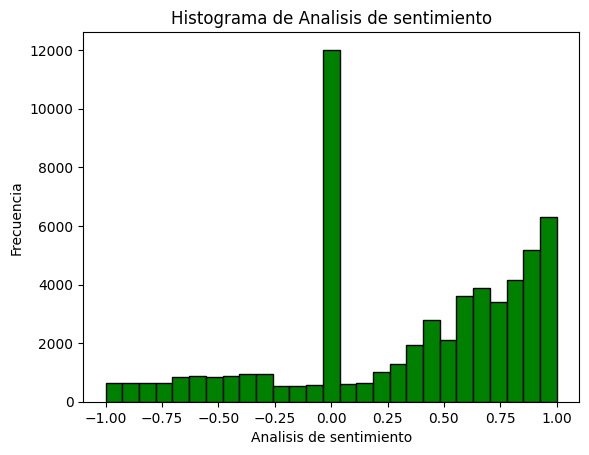

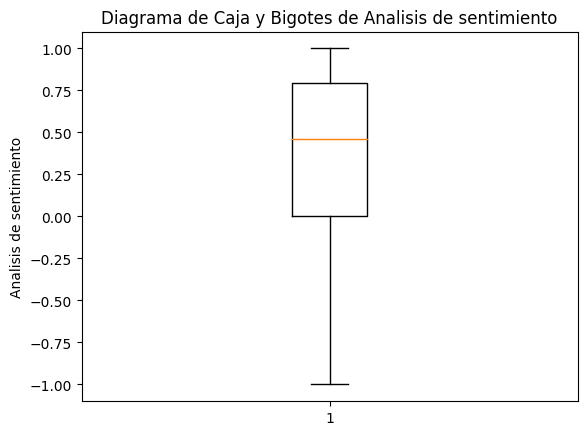

In [16]:
# Histograma
plt.hist(df_reviews['sentiment_analysis'], bins=27, color='green', edgecolor='black')
plt.xlabel('Analisis de sentimiento')
plt.ylabel('Frecuencia')
plt.title('Histograma de Analisis de sentimiento')
plt.show()

# Diagrama de Caja y bigotes
plt.boxplot(df_reviews['sentiment_analysis'])
plt.ylabel('Analisis de sentimiento')
plt.title('Diagrama de Caja y Bigotes de Analisis de sentimiento')
plt.show()

Desde el histograma es notable que existen 3 divisiones identificables, los valores inferiores a -0.25, los valores superiores a 0.11 y los valores entre estos 2 números.
Dado lo anterior, se clasificarán los reviews de la siguiente manera:
*   Review Positiva: Valores superiores a 0.11 , se les asignará un valor de 2
*   Review Neutral: Valores menores o iguales a 0.11 y mayores o iguales a -0.25, se les asignará un valor de 1
*   Review Negativa: Valores menores a -0.25, se les asignará un valor de 0.

Desde el diagrama de caja y bigotes se puede concluir rápidamente que menos del 25% de las reseñas serían negativas, mientras que más del 50% de ellas está en la categoría de positivas.

In [17]:
condiciones = [df_reviews['sentiment_analysis'] > 0.11,
              df_reviews['sentiment_analysis'] < -0.25]
valores = [2, 0]
df_reviews['sentiment_analysis'] = np.select(condiciones, valores, default=1)
del valores; del condiciones

### **Eliminación de la columna "review" en "df_reviews"**

In [18]:
df_reviews.drop('review', axis=1, inplace=True)

## **Transformaciones necesarias para la creación de dataframe para API-Render**


Las siguientes transformaciones tendrán como objetivo disminuir el tamaño del dataset para poder ser procesado y cargado en la API de Render, por lo que algunas decisiones serán tomadas con el propósito principal de disminuir el tamaño de los dataframes.

###desempaquetado de df_juegos.tags a df_juegos.tag

In [19]:
df_juegos['tags'] = df_juegos['tags'].apply(lambda x: x.strip("[]").split(", "))
df_juegos = df_juegos.explode('tags')
df_juegos.rename(columns={'tags': 'tag'}, inplace=True)
df_juegos['tag'] = df_juegos['tag'].str.replace("'", "")
df_juegos['tag'].replace(r'^.*?\[', '', regex=True, inplace=True)
df_juegos = df_juegos.drop_duplicates()
df_juegos['tag'] = df_juegos['tag'].str.lower()
del ast

## **Reducción de tamaño de dataframes por limitaciones de memoria**

Los siguientes pasos tienen la finalidad de reducir el tamaño de los dataframes para disminuir el consumo de memoria final.

### **Se verificará la cantidad de géneros existentes en el dataset, con el objetivo de seleccionar los más utilizados**

In [20]:
print("Número de elementos distintos en df_juegos.tag:", df_juegos['tag'].nunique())

Número de elementos distintos en df_juegos.tag: 350


### **nube depalabras**

Se generará una nube de plabras para visualizar de forma rápida la diferencia relativa de frecuencia de los distintos géneros

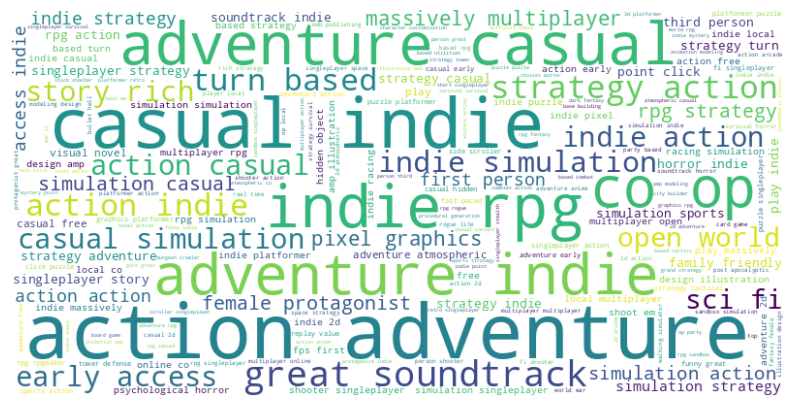

In [21]:
tags = ' '.join(df_juegos['tag'])
nube_palabras = WordCloud(width=800, height=400, background_color='white').generate(tags)
plt.figure(figsize=(10, 6))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')
plt.show()
del nube_palabras; del WordCloud; del tags;

### **Listado de frecuencia de palabras**

Se usará un listado de frecuencia de plabras para poder observar con más exactitud los valores de la nube de palabras.

In [22]:
tags_texto = ' '.join(df_juegos['tag'])
tags = tags_texto.split()
frecuencias = Counter(tags)
frecuencias = sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)
cantidad_palabras = 350
for i, (palabra, frecuencia) in enumerate(frecuencias):
    if i >= cantidad_palabras:
        break
    print(f'{palabra}: {frecuencia}')

del cantidad_palabras; del frecuencias; del tags
del tags_texto; del frecuencia; del i; del palabra

indie: 16208
action: 12294
adventure: 9319
casual: 8818
strategy: 7959
simulation: 7015
rpg: 6475
singleplayer: 4172
multiplayer: 4020
soundtrack: 2296
co-op: 2269
free: 2220
to: 2220
play: 2220
great: 2164
2d: 2038
puzzle: 2005
horror: 1917
shooter: 1856
atmospheric: 1831
turn-based: 1741
&: 1651
platformer: 1578
world: 1523
fantasy: 1487
early: 1427
access: 1427
story: 1404
rich: 1404
sports: 1313
sci-fi: 1288
open: 1264
anime: 1264
difficult: 1261
local: 1260
protagonist: 1236
massively: 1236
pixel: 1229
graphics: 1229
female: 1153
racing: 1123
survival: 1094
funny: 1065
design: 984
illustration: 984
first-person: 964
retro: 945
comedy: 942
fps: 922
sandbox: 920
arcade: 909
classic: 888
point: 857
click: 857
game: 753
space: 743
family: 728
friendly: 728
movie: 706
em: 705
up": 705
novel: 645
dark: 624
gore: 615
third: 606
person: 606
war: 606
visual: 602
&amp;: 580
tactical: 565
online: 561
exploration: 534
cute: 533
utilities: 524
"shoot: 517
hidden: 515
object: 515
zombies: 489
b

Aplicando la **ley de pareto** (80/20), se buscará el punto en que se cumple con el 80% del total de acumulación y se contarán los géneros hasta cumplir con éste porcentaje.

In [23]:
tags_texto = ' '.join(df_juegos['tag'])
tags = tags_texto.split()
frecuencias = Counter(tags)
frecuencias = sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)
frecuencia_total = sum(freq[1] for freq in frecuencias)
frecuencia_buscada = frecuencia_total * 0.8
frecuencia_acumulada = 0
palabra_buscada = None
palabras_en_rango = []
for palabra, frecuencia in frecuencias:
    frecuencia_acumulada += frecuencia
    if frecuencia_acumulada >= frecuencia_buscada:
        palabra_buscada = palabra
        break
    palabras_en_rango.append(palabra)

print(f'La palabra en la que se alcanza el 80% del total de frecuencias acumuladas es: {palabra_buscada}')
print(f'Número de palabras dentro del 80% del total de frecuencias acumuladas: {len(palabras_en_rango)}')
del frecuencia_acumulada; del frecuencia; del frecuencias; del tags; del tags_texto;
del frecuencia_buscada; del palabra_buscada; del frecuencia_total; del palabra;

La palabra en la que se alcanza el 80% del total de frecuencias acumuladas es: rpgmaker
Número de palabras dentro del 80% del total de frecuencias acumuladas: 81


### **Eliminación de géneros de los dataframes**

Según lo observado en el análisis anterior, se deberían dejar los 82 géneros más frecuentes, pero, por limitaciones de memoria, sólo se trabajará con los 5 más frecuentes, se dejarará comentado en el código el cambio que hay que hacer para respetar el resultado del análisis previo

In [24]:
tags_texto = ' '.join(df_juegos['tag'])
tags = tags_texto.split()
frecuencia_palabras = Counter(tags)
frecuencia_palabras = sorted(frecuencia_palabras.items(), key=lambda x: x[1], reverse=True)
frecuencia_total = sum(freq[1] for freq in frecuencia_palabras)
frecuencia_objetivo = frecuencia_total * 0.8
frecuencia_acumulada = 0
palabra_objetivo = None
for palabra, frecuencia in frecuencia_palabras:
    frecuencia_acumulada += frecuencia
    if frecuencia_acumulada >= frecuencia_objetivo:
        palabra_objetivo = palabra
        break
'''para cambiar la cantidad de palabras, hay que cambiar el valor numérico de la
siguiente línea de código, en este caso, cambiar 5 por 82'''
juegos_en_objetivo = set([palabra for palabra, _ in frecuencia_palabras[:5]])
df_juegos = df_juegos[df_juegos['tag'].isin(juegos_en_objetivo)]
del Counter; del frecuencia_acumulada; del frecuencia; del frecuencia_palabras; del tags;
del tags_texto; del frecuencia_objetivo; del palabra_objetivo; del juegos_en_objetivo;
del frecuencia_total; del palabra

**Se replicará la limpieza en los demás dataframes igualmente.**

In [25]:
juegos_en_objetivo = set(df_juegos['item_id'])
df_reviews = df_reviews[df_reviews['item_id'].isin(juegos_en_objetivo)]
df_items = df_items[df_items['item_id'].isin(juegos_en_objetivo)]
del juegos_en_objetivo

### **Análisis de correlaciones monovariado**

In [26]:
frecuencia_genero = df_juegos['tag'].value_counts().head(10)
recom_genero = df_reviews.merge(df_juegos[['tag', 'item_id']], on='item_id', how='inner') \
                                    .groupby('tag')['recommend'].mean() \
                                    .sort_values(ascending=False) \
                                    .reindex(frecuencia_genero.index).head(10)
tiempo_de_juego = df_items.merge(df_juegos[['tag', 'item_id']], on='item_id', how='inner') \
                             .groupby('tag')['playtime_forever'].sum() \
                             .reindex(frecuencia_genero.index).head(10)
tiempo_de_juego = tiempo_de_juego.sort_values(ascending=False).head(10)
print("Frecuencia de géneros:")
print(frecuencia_genero)
print("\nRecomendación promedio por género:")
print(recom_genero)
print("\nTiempo jugado por género:")
print(tiempo_de_juego)

del frecuencia_genero; del tiempo_de_juego; del recom_genero

Frecuencia de géneros:
indie        16208
action       11931
adventure     9138
casual        8818
strategy      7302
Name: tag, dtype: int64

Recomendación promedio por género:
indie        0.888269
action       0.894153
adventure    0.890123
casual       0.885615
strategy     0.890743
Name: recommend, dtype: float64

Tiempo jugado por género:
action       3969250805
adventure    2532692589
strategy     1987759960
indie        1609262647
casual        565868279
Name: playtime_forever, dtype: int64


De la frecuencia de géneros no se puede concluir nada nuevo, ya que es lo mismo que ya se ha visualizado previamente, sólo mencionar que el top 5 de géneros más frecuentes sería el siguiente:
"indie","action","adventure","casual" y "strategy"
de lo que se puede esperar que sean los géneros más prevalentes en las recomendaciones.

En cuanto a la recomendación promedio por género, aunque a simple vista se observa que todos los géneros son altamente recomendados, se puede observar también que los géneros más frecuentes no son claramente los más recomendados.

Finalmente, el tiempo jugado por género se puede analizar un poco más en profundidad, el género de "action" se ve como el género N° 1 con más tiempo de juego, esto tiene sentido ya que una gran parte de los juegos Multijugador Online entran en esta categoría, y son el tipo de producto que pueden ser rejugados más veces, lo que se correlaciona con que los siguientes puestos con mayor tiempo jugado son las categorías "multiplayer" y "co-op", es llamativo que luego continúa "singleplayer", todos con un tiempo de juego relativamente similar, luego pasamos a "adventure" y "strategy", es de esperar que los juegos más recomendados sean juegos de acción y aventura, específicamente que posean un fuerte componente multijugador cooperativo, y preferiblemente que tengan un modo historia en singleplayer o cooperativo.

### **Análisis de correlaciones Bivariado**

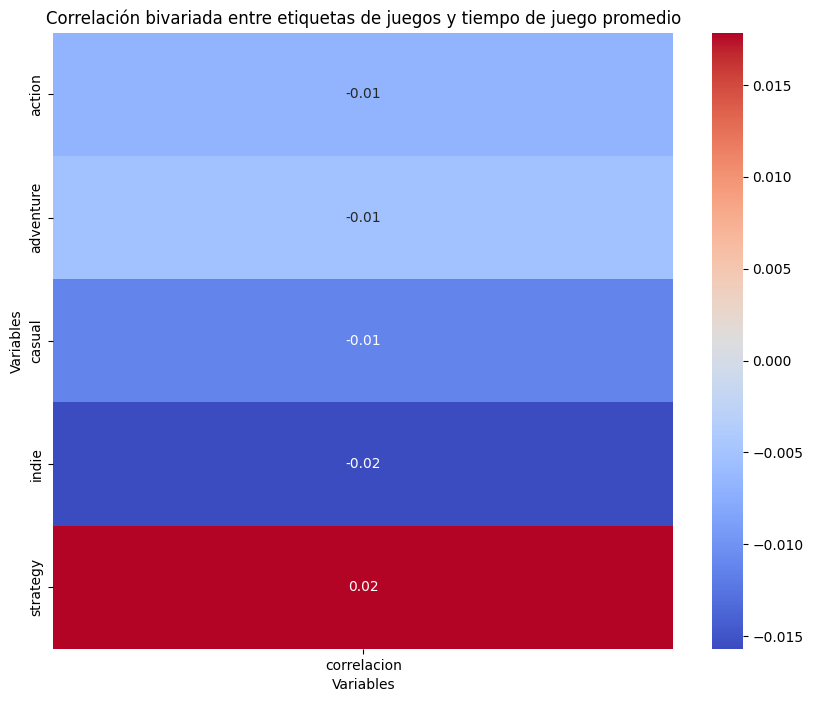

In [27]:
tiempo_promedio = df_items.groupby('item_id')['playtime_forever'].mean()
df_juegos['average_playtime'] = df_juegos['item_id'].map(tiempo_promedio)
lista_correlacion = []
for genero, grupo in df_juegos.groupby('tag'):
    correlacion = grupo['average_playtime'].corr(pd.Series(grupo.index, index=grupo.index))
    lista_correlacion.append((genero, correlacion))
df_correlacion = pd.DataFrame(lista_correlacion, columns=['genero', 'correlacion'])
df_correlacion.set_index('genero', inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(df_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación bivariada entre etiquetas de juegos y tiempo de juego promedio")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

del plt; del tiempo_promedio; del lista_correlacion; del df_correlacion


Se visualiza una relación positiva leve entre strategy y multiplayer, por lo que pueden tender a aumentar juntos, pero la relación sigue siendo debil.
Además, se visualiza una tendencia a la relación negativa debil en general, por lo que si aumenta alguna de las categorías, en general, las demás disminuyen.

### **Análisis de correlaciones multivariado**

In [28]:
matriz_juegos = df_juegos.corr(numeric_only=True)
matriz_reviews = df_reviews.corr(numeric_only=True)
matriz_items = df_items.corr(numeric_only=True)
matriz_combinada = pd.concat([matriz_juegos, matriz_reviews, matriz_items], axis=1)
print("Matriz de correlación combinada:")
print(matriz_combinada)

del matriz_juegos; del matriz_reviews; del matriz_items; del matriz_combinada

Matriz de correlación combinada:
                    release_date   item_id  average_playtime   item_id  \
release_date            1.000000  0.295218          0.022181       NaN   
item_id                 0.295218  1.000000         -0.026014  1.000000   
average_playtime        0.022181 -0.026014          1.000000       NaN   
recommend                    NaN       NaN               NaN -0.127515   
sentiment_analysis           NaN       NaN               NaN -0.041011   
playtime_forever             NaN       NaN               NaN       NaN   

                    recommend  sentiment_analysis   item_id  playtime_forever  
release_date              NaN                 NaN       NaN               NaN  
item_id             -0.127515           -0.041011  1.000000         -0.076468  
average_playtime          NaN                 NaN       NaN               NaN  
recommend            1.000000            0.251258       NaN               NaN  
sentiment_analysis   0.251258            1.00000

*   Se observa una correlación débil negativa (-0.07592) entre el item_id y el playtime_forever, lo cual es lógico, si un juego es más nuevo, se ha jugado menos tiempo.
*   Se observa una correlación negativa no tan débil (-0.128122) entre item_id y recommend, lo que indica que los juegos más nuevos se han recomendado menos que los juegos más antiguos, eso tiende a ser un efecto natural, ya que los juegos más antiguos han tenido más tiempo para ser recomendados, pero aplicar márketing u otras estrategias para cambiar esto no estaría mal, ya que los juegos más nuevos suelen tender a costar más dinero que un juego antiguo.

### **Eliminación de variables restantes**

In [29]:
del genero; del grupo; del palabras_en_rango; del sns

## **Creación de dataframes para la API**

### **df_PlayTimeGenre**

Se crea un dataframe con los siguientes datos:
*   genero (tag)
*   año (release_date)

In [30]:
generos = df_juegos['tag'].unique()
resultados = pd.DataFrame(columns=['genero', 'año'])
for genero in generos:
    df_genero = df_juegos[df_juegos['tag'] == genero]
    df_tiempo_jugado = df_genero.groupby('release_date')['average_playtime'].sum().reset_index()
    idx_max_tiempo_jugado = df_tiempo_jugado['average_playtime'].idxmax()
    año_max_tiempo_jugado = df_tiempo_jugado.loc[idx_max_tiempo_jugado, 'release_date']
    df_temporal = pd.DataFrame({'genero': [genero], 'año': [año_max_tiempo_jugado]})
    resultados = pd.concat([resultados, df_temporal], ignore_index=True)
df_PlayTimeGenre = resultados

### **df_UserForGenre**

Se crea un dataframe con los siguientes datos:
*   genero (tag)
*   user_id
*   año (release_date)
*   horas_jugadas(playtime_forever)

In [31]:
usuarios_mas_jugados_por_genero = {}
for genero in df_juegos['tag'].unique():
    df_juegos_genero = df_juegos[df_juegos['tag'] == genero]
    df_juegos_items = pd.merge(df_juegos_genero, df_items, on='item_id')
    usuario_mas_jugado = df_juegos_items.groupby('user_id')['playtime_forever'].sum().idxmax()
    usuarios_mas_jugados_por_genero[genero] = usuario_mas_jugado
datos_salida = []
for genero, usuario in usuarios_mas_jugados_por_genero.items():
    df_usuario_genero = df_items[(df_items['user_id'] == usuario) & (df_items['item_id'].isin(df_juegos[df_juegos['tag'] == genero]['item_id']))]
    for _, fila in df_usuario_genero.iterrows():
        año = df_juegos[df_juegos['item_id'] == fila['item_id']]['release_date'].values[0]
        horas_jugadas = fila['playtime_forever']
        datos_salida.append([genero, usuario, año, horas_jugadas])
df_UserForGenre = pd.DataFrame(datos_salida, columns=['genero', 'user_id', 'año', 'horas_jugadas'])
print(df_UserForGenre)


         genero       user_id   año  horas_jugadas
0        action       Sp3ctre  2010            249
1        action       Sp3ctre  2004         122426
2        action       Sp3ctre  2006          89357
3        action       Sp3ctre  2003           7673
4        action       Sp3ctre  2005          21339
...         ...           ...   ...            ...
3000  adventure  REBAS_AS_F-T  2014              0
3001  adventure  REBAS_AS_F-T  2010              0
3002  adventure  REBAS_AS_F-T  2017              0
3003  adventure  REBAS_AS_F-T  2016           6430
3004  adventure  REBAS_AS_F-T  2016              0

[3005 rows x 4 columns]


### **df_UsersRecommend**

Se crea un dataframe con los siguientes datos:
*   año (release_date)
*   puesto (dato calculado)
*   juego (app_name)

In [32]:
resultados = pd.DataFrame(columns=['año', 'puesto', 'juego'])
años = df_juegos['release_date'].unique()
for año in años:
    juegos_año = df_juegos[df_juegos['release_date'] == año]
    if juegos_año.empty:
        continue
    item_ids_año = juegos_año['item_id'].unique()
    reseñas_año = df_reviews[df_reviews['item_id'].isin(item_ids_año)]
    reseñas_positivas = reseñas_año[(reseñas_año['recommend'] == True) & (reseñas_año['sentiment_analysis'] >= 1)]
    top_juegos = reseñas_positivas['item_id'].value_counts().head(3)
    for i, (item_id, _) in enumerate(top_juegos.items(), start=1):
        juego_nombre = df_juegos[df_juegos['item_id'] == item_id]['app_name'].iloc[0]
        resultados = pd.concat([resultados, pd.DataFrame({'año': [año], 'puesto': [i], 'juego': [juego_nombre]})], ignore_index=True)
        resultados = resultados[resultados['año'] != 2222]
df_UsersRecommend = resultados


### **df_UsersNotRecommend**

Se crea un dataframe con los siguientes datos:
*   año (release_date)
*   puesto (dato calculado)
*   juego (app_name)

In [33]:
resultados = pd.DataFrame(columns=['año', 'puesto', 'juego'])
años = df_juegos['release_date'].unique()
for año in años:
    juegos_año = df_juegos[df_juegos['release_date'] == año]
    if juegos_año.empty:
        continue
    item_ids_año = juegos_año['item_id'].unique()
    reseñas_año = df_reviews[df_reviews['item_id'].isin(item_ids_año)]
    reseñas_no_recomendadas = reseñas_año[(reseñas_año['recommend'] == False) & (reseñas_año['sentiment_analysis'] == 0)]
    top_juegos = reseñas_no_recomendadas['item_id'].value_counts().tail(3)
    for i, (item_id, _) in enumerate(top_juegos.items(), start=1):
        juego_nombre = df_juegos[df_juegos['item_id'] == item_id]['app_name'].iloc[0]
        resultados = pd.concat([resultados, pd.DataFrame({'año': [año], 'puesto': [i], 'juego': [juego_nombre]})], ignore_index=True)
resultados = resultados[resultados['año'] != 2222]
df_UsersNotRecommend = resultados

### **df_sentiment_analysis**

Se crea un dataframe con los siguientes datos:
*   año (release_date)
*   categoría (positivo, neutral, negativo)
*   cantidad (dato calculado)

In [34]:
categorias_sentimiento = {0: 'negativo', 1: 'neutral', 2: 'positivo'}
df_juegos['release_date'] = pd.to_datetime(df_juegos['release_date'], format='%Y')
df_juegos['año'] = df_juegos['release_date'].dt.year
conteo_sentimiento = df_reviews.groupby(['item_id', 'sentiment_analysis']).size().reset_index(name='cantidad')
conteo_sentimiento['categoria'] = conteo_sentimiento['sentiment_analysis'].map(categorias_sentimiento)
conteo_sentimiento = pd.merge(conteo_sentimiento, df_juegos[['item_id', 'año']], on='item_id')
conteo_final = conteo_sentimiento.groupby(['año', 'categoria']).agg({'cantidad': 'sum'}).reset_index()
df_sentiment_analysis = conteo_final[conteo_final['año'] != 2222]
print(df_sentiment_analysis.head(20))


     año categoria  cantidad
0   1989  positivo         2
1   1990  negativo         1
2   1990  positivo         4
3   1991  positivo         1
4   1992  negativo         2
5   1992  positivo         4
6   1993  negativo         3
7   1993   neutral         3
8   1993  positivo         7
9   1994  negativo         2
10  1994   neutral         5
11  1994  positivo        11
12  1995  negativo         4
13  1995   neutral         2
14  1995  positivo        16
15  1996   neutral         3
16  1996  positivo         7
17  1997  negativo        11
18  1997   neutral        15
19  1997  positivo        60


### **df_recomendacion_juego**

antes de procesar los últimos 2 dataframes, harémos una limpieza de variables locales para liberar memoria.

In [36]:
del año; del año_max_tiempo_jugado; del años
del categorias_sentimiento; del conteo_final; del conteo_sentimiento
del correlacion; del datos_salida; del df_juegos_genero; del df_juegos_items;
del df_temporal; del df_tiempo_jugado; del df_usuario_genero; del fila
del genero; del generos; del horas_jugadas; del i; del idx_max_tiempo_jugado;
del item_id; del item_ids_año; del juego_nombre; del juegos_año; del reseñas_año
del reseñas_no_recomendadas; del reseñas_positivas; del resultados
del top_juegos; del usuario; del usuario_mas_jugado
del usuarios_mas_jugados_por_genero

Se crea un dataframe con los siguientes datos:
*   id_juego (item_id)
*   nombre_juego (app_name)
*   puesto (dato calculado)
*   juego (app_name)

In [37]:
'''Dataframe en construcción, se aplica el modelo de similitud del coseno Item a Item'''

'Dataframe en construcción, se aplica el modelo de similitud del coseno Item a Item'

### **df_recomendacion_usuario**

Se crea un dataframe con los siguientes datos:
*   id_usuario (user_id)
*   puesto (dato calculado)
*   juego (app_name)

In [38]:
'''Dataframe en construcción, se aplica el modelo de similitud del coseno user a Item'''

'Dataframe en construcción, se aplica el modelo de similitud del coseno user a Item'

# **Exportación de datos en formato csv**

In [39]:
df_PlayTimeGenre.to_csv('df_PlayTimeGenre.csv', index=False, header=True)
df_UserForGenre.to_csv('df_UserForGenre.csv', index=False, header=True)
df_UsersRecommend.to_csv('df_UsersRecommend.csv', index=False, header=True)
df_UsersNotRecommend.to_csv('df_UsersNotRecommend.csv', index=False, header=True)
df_sentiment_analysis.to_csv('df_sentiment_analysis.csv', index=False, header=True)
#df_recomendacion_juego.to_csv('recommendacion_juego.csv', index=False, header=True)
#df_recomendacion_usuario.to_csv('recommendacion_usuario.csv', index=False, header=True)